In [30]:
#Import all libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# PROCESSAMENTO DE DADOS

In [31]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import re
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ast
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage import *
import tensorflow as tf
from keras import *
from PIL import Image
import matplotlib

In [32]:
# Function to read in Marks
def read_xml(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return lines

In [33]:
# Get a list of files in Thyroid with Segmentatin Coordinates
filenames = glob.glob("C:/Users/Bernardo/TCC/thyroid/*")

In [34]:
# Create List of Images Files
images = [x for x in filenames if x.endswith(".jpg")]

# Create List of Segments
segments = [x for x in filenames if x.endswith(".xml")]

In [35]:
# Create List of Marks
marks = [read_xml(file) for file in segments]

In [36]:
#Iniciano um dicionario
temp_dict = {}

#Criando um dicionario com o id de cada imagem como o indice e as marcas da roi como os valores de entrada
for i in marks:
    pattern = r"<case>(.*?)</case>"
    temp = re.findall(pattern, str(i))[0]
    
    id_1 = re.findall(r"<number>(.*?)</number>",temp)[0]
    id_2 = re.findall(r"<image>(.*?)</image>",temp)
    
    for t in id_2:
        pattern = r"<image>"+t+"</image><svg>(.*?)</svg>"
        temp_dict[id_1+'_'+t] = re.findall(pattern,temp)

In [37]:
# Create DataFrame from Dictionary
segments = pd.DataFrame.from_dict(temp_dict, orient='index').reset_index()

# Rename columns
segments = segments.rename(columns = {'index':'img_id',0:"mark"})

segments.head()

,img_id,mark
0,1_1,"[{""points"": [{""x"": 385, ""y"": 182}, {""x"": 398, ..."
1,1_2,"[{""points"": [{""x"": 417, ""y"": 155}, {""x"": 418, ..."
2,10_1,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ..."
3,100_1,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""..."
4,101_1,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ..."


In [38]:
#Adicionando o nome do arquivo ao id criado do paciente. 
#Aplicando função function, sendo x as entradas do segments["img_id"]
#def aa(x):
#    "thyroid/"+x+".jpg"
#segments['img_id'] = segments["img_id"].apply(aa)
segments['img_id'] = segments["img_id"].apply(lambda x: "thyroid/"+x+".jpg")

In [39]:
segments.head()


,img_id,mark
0,thyroid/1_1.jpg,"[{""points"": [{""x"": 385, ""y"": 182}, {""x"": 398, ..."
1,thyroid/1_2.jpg,"[{""points"": [{""x"": 417, ""y"": 155}, {""x"": 418, ..."
2,thyroid/10_1.jpg,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ..."
3,thyroid/100_1.jpg,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""..."
4,thyroid/101_1.jpg,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ..."


In [40]:
#Iniciano um dicionario
temp_dict1 = {}

#Criando um dicionario com o id de cada imagem como o indice e as marcas da roi como os valores de entrada
for i in marks:
    pattern1 = r"<case>(.*?)</case>"
    temp1 = re.findall(pattern1, str(i))[0]
    
    id_11 = re.findall(r"<number>(.*?)</number>",temp1)[0]
    id_21 = re.findall(r"<image>(.*?)</image>",temp1)
    
    for t in id_21:
        pattern1 = r"<tirads>(.*?)</tirads>"
        temp_dict1[id_11+'_'+t] = re.findall(pattern1,temp1)

In [41]:

# Create DataFrame from Dictionary
df_temp_dict1 = pd.DataFrame.from_dict(temp_dict1, orient='index').reset_index()

# Rename columns
df_temp_dict1 = df_temp_dict1.rename(columns = {'index':'img_id1',0:"tirads"})

df_temp_dict1.head()

,img_id1,tirads
0,1_1,
1,1_2,
2,10_1,4b
3,100_1,4a
4,101_1,5


In [42]:
df_temp_dict1['img_id1'] =df_temp_dict1["img_id1"].apply(lambda x: "thyroid/"+x+".jpg")

In [43]:
dados=[segments, df_temp_dict1]

In [44]:
#concatenando os dataframes
segments=pd.concat(dados, axis=1)

In [45]:
segments.head()

,img_id,mark,img_id1,tirads
0,thyroid/1_1.jpg,"[{""points"": [{""x"": 385, ""y"": 182}, {""x"": 398, ...",thyroid/1_1.jpg,
1,thyroid/1_2.jpg,"[{""points"": [{""x"": 417, ""y"": 155}, {""x"": 418, ...",thyroid/1_2.jpg,
2,thyroid/10_1.jpg,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ...",thyroid/10_1.jpg,4b
3,thyroid/100_1.jpg,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""...",thyroid/100_1.jpg,4a
4,thyroid/101_1.jpg,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ...",thyroid/101_1.jpg,5


In [46]:
#excluindo a columa img_id1
segments=segments.drop(columns=['img_id1'])


In [47]:
#quantos que nao tinham as marks sairam
mark_out=np.where(segments['mark']=="")[0]

In [48]:
#quantos que nao tinham a avaliaçao tirads sairam
tirads_out=np.where(segments['tirads']=="")[0]

In [49]:
#Retirando as entradas do df que não tem nada
segments = segments[segments['mark']!=""]

In [50]:
#Retirando as entradas do df que não tem nada
segments = segments[segments['tirads']!=""]

In [51]:
# Break up Marks
pattern = r'"points"(.*?)"annotation"'
segments["mark_1"] = segments["mark"].apply(lambda x: re.findall(pattern, x)[0])
segments["mark_2"] = segments["mark"].apply(lambda x: re.findall(pattern, x)[1] if len(re.findall(pattern, x)) > 1 else "")


In [52]:
segments.head()

,img_id,mark,tirads,mark_1,mark_2
2,thyroid/10_1.jpg,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ...",4b,": [{""x"": 326, ""y"": 172}, {""x"": 332, ""y"": 172},...",
3,thyroid/100_1.jpg,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""...",4a,": [{""x"": 164, ""y"": 31}, {""x"": 159, ""y"": 31}, {...",": [{""x"": 381, ""y"": 24}, {""x"": 370, ""y"": 28}, {..."
4,thyroid/101_1.jpg,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ...",5,": [{""x"": 224, ""y"": 156}, {""x"": 224, ""y"": 147},...",": [{""x"": 462, ""y"": 157}, {""x"": 462, ""y"": 152},..."
5,thyroid/102_1.jpg,"[{""points"": [{""x"": 219, ""y"": 73}, {""x"": 217, ""...",4b,": [{""x"": 219, ""y"": 73}, {""x"": 217, ""y"": 68}, {...",": [{""x"": 410, ""y"": 124}, {""x"": 422, ""y"": 118},..."
6,thyroid/103_1.jpg,"[{""points"": [{""x"": 208, ""y"": 120}, {""x"": 211, ...",4a,": [{""x"": 208, ""y"": 120}, {""x"": 211, ""y"": 115},...",": [{""x"": 407, ""y"": 116}, {""x"": 413, ""y"": 109},..."


In [53]:
#criando o vetor para ser os novos indices do dataframe
new_index=[]
for i in range (len(segments)):
    new_index1=i
    new_index.append(new_index1)
new_index=np.array(new_index)

In [54]:
#dataframe com os indices reordenados
segments=segments.set_index(new_index)
segments

,img_id,mark,tirads,mark_1,mark_2
0,thyroid/10_1.jpg,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ...",4b,": [{""x"": 326, ""y"": 172}, {""x"": 332, ""y"": 172},...",
1,thyroid/100_1.jpg,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""...",4a,": [{""x"": 164, ""y"": 31}, {""x"": 159, ""y"": 31}, {...",": [{""x"": 381, ""y"": 24}, {""x"": 370, ""y"": 28}, {..."
2,thyroid/101_1.jpg,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ...",5,": [{""x"": 224, ""y"": 156}, {""x"": 224, ""y"": 147},...",": [{""x"": 462, ""y"": 157}, {""x"": 462, ""y"": 152},..."
3,thyroid/102_1.jpg,"[{""points"": [{""x"": 219, ""y"": 73}, {""x"": 217, ""...",4b,": [{""x"": 219, ""y"": 73}, {""x"": 217, ""y"": 68}, {...",": [{""x"": 410, ""y"": 124}, {""x"": 422, ""y"": 118},..."
4,thyroid/103_1.jpg,"[{""points"": [{""x"": 208, ""y"": 120}, {""x"": 211, ...",4a,": [{""x"": 208, ""y"": 120}, {""x"": 211, ""y"": 115},...",": [{""x"": 407, ""y"": 116}, {""x"": 413, ""y"": 109},..."
5,thyroid/105_1.jpg,"[{""points"": [{""x"": 159, ""y"": 55}, {""x"": 148, ""...",4a,": [{""x"": 159, ""y"": 55}, {""x"": 148, ""y"": 58}, {...",": [{""x"": 403, ""y"": 60}, {""x"": 392, ""y"": 65}, {..."
6,thyroid/107_1.jpg,"[{""points"": [{""x"": 428, ""y"": 144}, {""x"": 437, ...",4a,": [{""x"": 428, ""y"": 144}, {""x"": 437, ""y"": 142},...",": [{""x"": 165, ""y"": 114}, {""x"": 159, ""y"": 114},..."
7,thyroid/108_1.jpg,"[{""points"": [{""x"": 294, ""y"": 84}, {""x"": 287, ""...",4a,": [{""x"": 294, ""y"": 84}, {""x"": 287, ""y"": 84}, {...",
8,thyroid/109_1.jpg,"[{""points"": [{""x"": 293, ""y"": 148}, {""x"": 293, ...",4b,": [{""x"": 293, ""y"": 148}, {""x"": 293, ""y"": 140},...",
9,thyroid/11_1.jpg,"[{""points"": [{""x"": 292, ""y"": 57}, {""x"": 288, ""...",5,": [{""x"": 292, ""y"": 57}, {""x"": 288, ""y"": 57}, {...",


TypeError: Invalid dimensions for image data

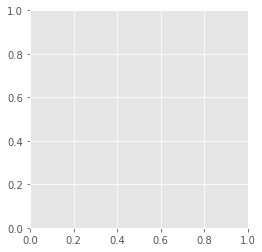

In [59]:
tirads_vec= [] 
dst2_vec=[]
count=[]
for j in range (0, len(segments['mark'])):
    if segments['mark_2'][j]!="":
        test=segments.loc[segments['img_id']==segments['img_id'][j]]
        l = test['mark_2'].get_values()[0]
        i = 0
        t = 0

        test_1 = re.findall(r"\d+", l) #encontrando todos aqueles digitos entre aspas com 1 ou mais digitos do "vetor" l

        dims = len(test_1)//2 #a dimensão pro x é dims//2 e pro y dims//2 (colocam // provavelmente pq deve dar um numero quebrado)

        temp = np.empty([dims, 2]) 
        
        while i < dims:
            temp[i] = (test_1[t], test_1[t+1]) #Pegando a primeira entrada e a proxima do temp (x, y)
            i = i+1 #atualiza o indice do x
            t = t+2 #atualiza o indice do y
            
        diretorio= "C:/Users/Bernardo/TCC/"
        img = cv2.imread(diretorio+segments['img_id'][j], cv2.IMREAD_GRAYSCALE)
        

           ## (1) Crop the bounding rect
        rect = cv2.boundingRect(temp.astype('i4'))
        x,y,w,h = rect
        croped = img[y:y+h, x:x+w].copy()


        dst2_vec.append(croped.tolist())
        
        tirads_vec1= segments.iloc[i]['tirads']
        tirads_vec.append(tirads_vec1)        
        
        
        l = test['mark_1'].get_values()[0]
        i = 0
        t = 0

        test_1 = re.findall(r"\d+", l) #encontrando todos aqueles digitos entre aspas com 1 ou mais digitos do "vetor" l

        dims = len(test_1)//2 #a dimensão pro x é dims//2 e pro y dims//2 (colocam // provavelmente pq deve dar um numero quebrado)

        temp = np.empty([dims, 2]) 
        
        while i < dims:
            temp[i] = (test_1[t], test_1[t+1]) #Pegando a primeira entrada e a proxima do temp (x, y)
            i = i+1 #atualiza o indice do x
            t = t+2 #atualiza o indice do y

        diretorio= "C:/Users/Bernardo/TCC/"
        img = cv2.imread(diretorio+segments['img_id'][j], cv2.IMREAD_GRAYSCALE)

           ## (1) Crop the bounding rect
        rect = cv2.boundingRect(temp.astype('i4'))
        x,y,w,h = rect
        croped = img[y:y+h, x:x+w].copy()




             
        dst2_vec.append(croped.tolist())
        tirads_vec1= segments.iloc[i]['tirads']
        tirads_vec.append(tirads_vec1)
        

    else:
        test=segments.loc[segments['img_id']==segments['img_id'][j]]
        l = test['mark_1'].get_values()[0]
        
        
        i = 0
        t = 0

        test_1 = re.findall(r"\d+", l) #encontrando todos aqueles digitos entre aspas com 1 ou mais digitos do "vetor" l

        dims = len(test_1)//2 #a dimensão pro x é dims//2 e pro y dims//2 (colocam // provavelmente pq deve dar um numero quebrado)

        temp = np.empty([dims, 2]) 
        
        while i < dims:
            temp[i] = (test_1[t], test_1[t+1]) #Pegando a primeira entrada e a proxima do temp (x, y)
            i = i+1 #atualiza o indice do x
            t = t+2 #atualiza o indice do y

        diretorio= "C:/Users/Bernardo/TCC/"
        img = cv2.imread(diretorio+segments['img_id'][j], cv2.IMREAD_GRAYSCALE)

           ## (1) Crop the bounding rect
        rect = cv2.boundingRect(temp.astype('i4'))
        x,y,w,h = rect
        croped = img[y:y+h, x:x+w].copy()

 
        

        
        dst2_vec.append(croped.tolist())
        tirads_vec1= segments.iloc[i]['tirads']
        tirads_vec.append(tirads_vec1)
        
        

        

In [27]:
df_dados=pd.DataFrame([dst2_vec,tirads_vec])
df_dados=df_dados.transpose()
df_dados.columns=[ 'marks', 'tirads']
df_dados

,marks,tirads
0,"[[93, 77, 70, 76, 79, 87, 98, 108, 117, 129, 1...",4a
1,"[[19, 30, 43, 54, 61, 57, 48, 40, 32, 25, 48, ...",4c
2,"[[52, 51, 33, 39, 58, 73, 65, 50, 56, 74, 53, ...",4b
3,"[[85, 109, 111, 99, 103, 109, 104, 99, 97, 86,...",4c
4,"[[124, 119, 108, 101, 93, 105, 109, 110, 105, ...",4c


In [28]:
df_dados=df_dados.drop(296)
df_dados=df_dados.drop(297)
df_dados=df_dados.drop(299)
df_dados=df_dados.drop(327)
df_dados=df_dados.drop(338)
df_dados=df_dados.drop(361)
df_dados=df_dados.drop(371)
df_dados=df_dados.drop(386)

In [29]:
df_dados.to_csv('df_dados_quadrado.csv')

In [ ]:
bbb=[]
for i in range (460):
    bbb.append(str(i))

In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)


In [ ]:
ben_mal=[]
for i in range (len(df_dados['tirads'])):
    if df_dados['tirads'][i]==str(2) or df_dados['tirads'][i]==str(3):
        ben_mal1=0
        
        ben_mal.append(ben_mal1)
    else:
        ben_mal1=1
        
        ben_mal.append(ben_mal1)
y=ben_mal

In [ ]:
y

In [ ]:
#Convert images & masks to arrays
for id_ in range (len(ids)):
    # Load images
    img = load_img("/Users/Bernardo/TCC/recorte/"+str(id_)+'.png', grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[id_] = x_img
X=X.astype('float32')/255
X